In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# function that takes a set of parameters, producing a lightcurve mathematical function
import sncosmo
model = sncosmo.Model(source='hsiao')
model.set(z=0.5, t0=55000., amplitude=1.e-10)

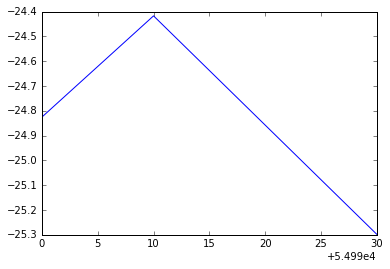

In [10]:
# function that takes evaluates lightcurve function given a sampling strategy
times = [54990., 55000., 55020.]
samples = -1.*np.array(model.bandmag('desr', 'ab', times))
plt.plot(times,samples)

/Users/aimalz/anaconda/lib/python2.7/site-packages/sncosmo/models.py:168: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


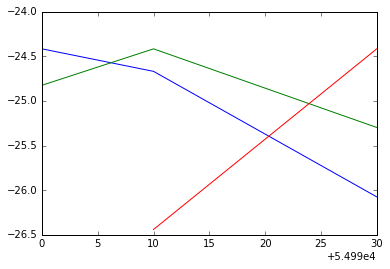

In [11]:
# function that shifts lightcurve sampling, creating many samplings of same underlying lightcurve
for x in times:
    model.set(z=0.5, t0=x, amplitude=1.e-10)
    sample = -1.*np.array(model.bandmag('desr', 'ab', times))
    plt.plot(times,sample)
plt.show()

In [ ]:
# function that fits lightcurves to samples, producing some set of parameters

In [ ]:
# function that calculates the variance of the fit parameters relative to the true parameters

In [ ]:
# function that bias of fit parameters relative to true parameters

In [ ]:
# function that calculates expected value of variance and bias for a set of lightcurves

In [ ]:
# choose a sampling strategy
# choose number of lightcurves to shift
# for each shifted lightcurve, evaluate at sampling locations (no measurement errors for now)
# for each shifted lightcurve, calculate variance of parameters, then sum them to get expected value of variance
# profit